# Profit and Loss Historical Simulation

- Take the past 1 year worth of historical data,
- for each no-premium fee calculation (BSM, MC Normal, etc.),
- assume a 180 samples lookback fee calculation
- calculate the PnL of each period
- take a look at the Profit and Loss distribution and cummulative PnL over time
- evaluate the results
- compare with-fees vs no-fees

In [90]:

import math
import random as random

import pandas as pd

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

# fixes the seed for reproducibility
rng = default_rng(99)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy
from scipy.optimize import fsolve

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'


# BSM Premium calculator
def bsm_premium(S0, K, T, sigma):
    # init
    r = 0.0
    # bsm terms
    d1 = (log(S0/K) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
    d2 = d1 - sigma * sqrt(T)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    # bsm premium
    BSM_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
    
    return BSM_premium

# BSM Fee calculator
def bsm_no_premium_call_option_fee(S0, T, sigma):
    # BSM no-premium option strike calculator
    def bsm_no_premium_strike(S0, T, sigma):
        # init
        r = 0.0
        K_at_money = S0
        # bsm terms
        d1 = (log(S0/K_at_money) + (r + 0.5 * sigma**2) * T) / sigma / sqrt(T)
        d2 = d1 - sigma * sqrt(T)
        N_d1 = norm.cdf(d1)
        N_d2 = norm.cdf(d2)
        
        def bsm_premium(K):
            # bsm premium
            BSM_C0_no_premium = S0 * N_d1 - K * exp(-r*T) * N_d2
            return BSM_C0_no_premium
        
        K_no_premium = fsolve(bsm_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = bsm_no_premium_strike(S0, T, sigma)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Normal Fee calculator
def mc_no_premium_call_option_fee(S0, T, sigma, I):
    # MC no-premium option strike calculator
    def mc_no_premium_strike(S0, T, sigma, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp((r - sigma ** 2 / 2) * T + sigma * math.sqrt(T) * mc_rng.standard_normal(I))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_no_premium_strike(S0, T, sigma, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Laplace Fee calculator
def mc_laplace_no_premium_call_option_fee(S0, T, sample, I):
    # Fit the Laplace PDF.
    loc,scale = laplace.fit(sample)
    # MC Laplace no-premium option strike calculator
    def mc_laplace_no_premium_strike(S0, T, loc, scale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp(laplace.rvs(loc, scale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_laplace_no_premium_strike(S0, T, loc, scale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# MC Student's t Fee calculator
def mc_student_t_no_premium_call_option_fee(S0, T, sample, I):
    # Fit the Student's t PDF.
    df, tloc, tscale = student_t.fit(sample)
    # MC Student's t no-premium option strike calculator
    def mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I):
        # init
        r = 0.0
        K_at_money = S0

        # underlying price vector at maturity
        mc_rng = default_rng(99)
        ST = S0 * np.exp(student_t.rvs(df, tloc, tscale, size=I, random_state=99))

        def mc_premium(K):
            # not exercised
            CT_below_K_at_money = ST[ST <= K_at_money] * 0

            # exercised at a loss
            CT_below_K = ST[ST > K_at_money]
            CT_below_K = CT_below_K[CT_below_K <= K] - K

            # exercised at a gain
            CT_above_K = ST[ST > K] - K

            # call option payoff at maturity
            CT_no_premium = np.concatenate((CT_below_K_at_money, CT_below_K, CT_above_K))

            CT_no_premium_mean = CT_no_premium.mean()

            # call option fair value
            MC_C0_no_premium = math.exp(-r * T) * CT_no_premium_mean

            return MC_C0_no_premium
        
        K_no_premium = fsolve(mc_premium, K_at_money)[0]
        
        return K_no_premium

    K_no_premium = mc_student_t_no_premium_strike(S0, T, df, tloc, tscale, I)

    fee = (K_no_premium-S0)/S0

    return fee

# Data set
btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

# Using the past year only
# nb_2min_in_1y = 365*24*60
# ret_2min = btcusd_1min['ret_2min'][-nb_2min_in_1y:]
btcusd_1min = btcusd_1min.truncate(before='2021-05-31')

# calc 2min log-returns
btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))
ret_2min = btcusd_1min['ret_2min']

# the 2-min vol
vol_2min = ret_2min.std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


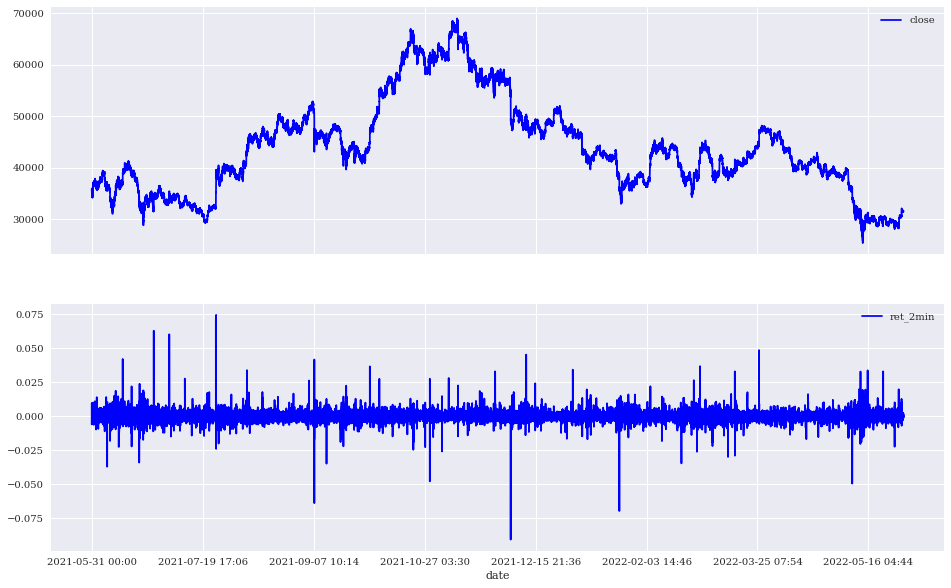

In [91]:

btcusd_1min[['close', 'ret_2min']].plot(subplots=True, style='b', figsize=(16, 10))

plt.show()

In [92]:

# risk free rate (no present value discounting)
r = 0.0

# 2min yearly fraction
T = 1 / (60/2 * 24 * 365.25)

# annualized 2min volatility
sigma = vol_ann

# number of price simulations
I = 1_000_000

# sample size
N = btcusd_1min['close'].size

header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|T|{float('%.3g' % T)}|\n"
table += f"|r|{r}|\n"
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"
table += f"|I|{I}|\n"

table2 = ""
table2 += f"|Samples| past 1 year|\n"
table2 += f"|N|{N}|\n"

md(f"""### Simulation variables
{header}
{table}
{header}
{table2}
""")


### Simulation variables
|variable|value|
|:-:|-:|
|T|3.8e-06|
|r|0.0|
|σ|81.486%|
|I|1000000|

|variable|value|
|:-:|-:|
|Samples| past 1 year|
|N|365779|



In [93]:

# N_lookback = 180
# element = -1

# # calc
# ret_2min_lookback = btcusd_1min['ret_2min'][-N_lookback+element:element]
# close_2min_lookback = btcusd_1min['close'][-N_lookback+element:]

# # underlying price at t=0
# # S0 = close_2min_lookback[-17-3]
# # ST = close_2min_lookback[-17-1]
# S0 = close_2min_lookback[element]
# ST = close_2min_lookback[element+2]

# # # BSM volatility
# vol_2min = ret_2min_lookback.std()
# vol_ann = vol_2min * sqrt(nb_2min_per_year)
# sigma = vol_ann

# # calc bsm at the money premium
# bsm_c0 = bsm_premium(S0, S0, T, sigma)

# # calc bsm at-the-money option payoffs
# bsm_at_the_money_ct = ST - S0
# # calc bsm at-the-money pnl
# bsm_at_the_money_pnl = -bsm_at_the_money_ct

# # calc bsm fee
# bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)
# # calc bsm strike
# bsm_strike = S0 * (1 + bsm_fee)
# # calc bsm option payoffs
# bsm_ct = ST - bsm_strike
# # calc bsm pnl
# bsm_pnl = -bsm_ct

# # calc mc normal fee
# mc_normal_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)
# # calc mc normal strike
# mc_normal_strike = S0 * (1 + mc_normal_fee)
# # calc mc normal option payoffs
# mc_normal_ct = ST - mc_normal_strike
# # calc mc normal pnl
# mc_normal_pnl = -mc_normal_ct # i.e. get the no-premium strike at the cost of the terminal price

# # calc mc laplace fee
# mc_laplace_fee = mc_laplace_no_premium_call_option_fee(S0, T, ret_2min_lookback, I)
# # calc mc laplace strike
# mc_laplace_strike = S0 * (1 + mc_laplace_fee)
# # calc mc laplace option payoffs
# mc_laplace_ct = ST - mc_laplace_strike
# # calc mc laplace pnl
# mc_laplace_pnl = -mc_laplace_ct

# # calc mc student's t fee
# mc_student_t_fee = mc_student_t_no_premium_call_option_fee(S0, T, ret_2min_lookback, I)
# # calc mc student's t strike
# mc_student_t_strike = S0 * (1 + mc_student_t_fee)
# # calc mc student's t option payoffs
# mc_student_t_ct = ST - mc_student_t_strike
# # calc mc student's t pnl
# mc_student_t_pnl = -mc_student_t_ct


# # [S0, ST, close_2min_lookback.tail(20),ret_2min_lookback.tail(5), ret_2min_lookback.size]
# [
#     ret_2min_lookback, 
#     close_2min_lookback,
#     ret_2min_lookback.size,
#     vol_2min,
#     sigma,
#     -N_lookback+element,
#     S0,
#     ST,
#     bsm_c0,
#     bsm_strike,
#     mc_normal_strike,
#     mc_laplace_strike,
#     mc_student_t_strike
# ]

In [94]:


header = '''|variable|value|
|:-:|-:|'''

table = ""
table += f"|σ|{float('%.5g' % (sigma*100))}%|\n"

table2 = ""
table2 += f"|S(0)|{float('%.8g' % S0)} USD|\n"
table2 += f"|BSM strike|{float('%.7g' % bsm_strike)} USD|\n"
table2 += f"|MC Normal strike|{float('%.7g' % mc_normal_strike)} USD|\n"
table2 += f"|MC Laplace strike|{float('%.7g' % mc_laplace_strike)} USD|\n"
table2 += f"|MC Student's t strike|{float('%.7g' % mc_student_t_strike)} USD|\n"

table3 = ""
table3 += f"|BSM fee|{float('%.5g' % (bsm_fee*100))}%|\n"
table3 += f"|MC Normal fee|{float('%.5g' % (mc_normal_fee*100))}%|\n"
table3 += f"|MC Laplace fee|{float('%.5g' % (mc_laplace_fee*100))}%|\n"
table3 += f"|MC Student's t fee|{float('%.5g' % (mc_student_t_fee*100))}%|\n"

table4 = ""
table4 += f"|BSM PnL|{float('%.7g' % bsm_pnl)} USD|\n"
table4 += f"|MC Normal PnL|{float('%.7g' % mc_normal_pnl)} USD|\n"
table4 += f"|MC Laplace PnL|{float('%.7g' % mc_laplace_pnl)} USD|\n"
table4 += f"|MC Student's t PnL|{float('%.7g' % mc_student_t_pnl)} USD|\n"

table5 = ""
table5 += f"|BSM premuim|{float('%.4g' % bsm_c0)} USD|\n"

md(f"""### Data fitting stats
{header}
{table}
### At-the-money Premium
{header}
{table5}
### Calculated Strikes
{header}
{table2}
### Calculated Fees
{header}
{table3}
### Calculated PnLs
{header}
{table4}
""")


### Data fitting stats
|variable|value|
|:-:|-:|
|σ|81.486%|

### At-the-money Premium
|variable|value|
|:-:|-:|
|BSM premuim|8.702 USD|

### Calculated Strikes
|variable|value|
|:-:|-:|
|S(0)|31605.2 USD|
|BSM strike|31622.61 USD|
|MC Normal strike|31622.61 USD|
|MC Laplace strike|31621.59 USD|
|MC Student's t strike|31625.72 USD|

### Calculated Fees
|variable|value|
|:-:|-:|
|BSM fee|0.055081%|
|MC Normal fee|0.05508%|
|MC Laplace fee|0.051873%|
|MC Student's t fee|0.064923%|

### Calculated PnLs
|variable|value|
|:-:|-:|
|BSM PnL|79.60847 USD|
|MC Normal PnL|79.60818 USD|
|MC Laplace PnL|78.59448 USD|
|MC Student's t PnL|82.719 USD|



In [95]:
# define historical simulation per iteration task

# bootstrap per iteration task
def historical_simulation(i, N_lookback):
    # indices
    curr_idx = -i
    look_idx = -i - N_lookback

    # lookback array to extract stats from
    lookback = btcusd_1min['ret_2min'][look_idx:curr_idx]

    # underlying price at t=0
    S0 = btcusd_1min['close'][curr_idx]
    
    # print(f'lookback = {lookback}')
    # print(f'curr_idx = {curr_idx}')
    # print(f'look_idx = {look_idx}')
    # print(f'lookback.size = {lookback.size}')
    # print(f'S0 = {S0}')

    # BSM volatility
    vol_2min = lookback.std()
    vol_ann = vol_2min * sqrt(nb_2min_per_year)
    sigma = vol_ann

    # print(f'vol_2min = {vol_2min}')
    # print(f'nb_2min_per_year = {nb_2min_per_year}')
    # print(f'vol_ann = {vol_ann}')


    # calc bsm at the money premium
    bsm_c0 = bsm_premium(S0, S0, T, sigma)
    btcusd_1min['bsm_c0'][curr_idx] = bsm_c0

    # calc bsm fee
    bsm_fee = bsm_no_premium_call_option_fee(S0, T, sigma)
    # calc bsm strike
    bsm_strike = S0 * (1 + bsm_fee)
    btcusd_1min['bsm_strike'][curr_idx] = bsm_strike

    # calc mc normal fee
    mc_normal_fee = mc_no_premium_call_option_fee(S0, T, sigma, I)
    # calc mc normal strike
    mc_normal_strike = S0 * (1 + mc_normal_fee)
    btcusd_1min['mc_normal_strike'][curr_idx] = mc_normal_strike

    # calc mc laplace fee
    mc_laplace_fee = mc_laplace_no_premium_call_option_fee(S0, T, lookback, I)
    # calc mc laplace strike
    mc_laplace_strike = S0 * (1 + mc_laplace_fee)
    btcusd_1min['mc_laplace_strike'][curr_idx] = mc_laplace_strike

    # calc mc student's t fee
    mc_student_t_fee = mc_student_t_no_premium_call_option_fee(S0, T, lookback, I)
    # calc mc student's t strike
    mc_student_t_strike = S0 * (1 + mc_student_t_fee)
    btcusd_1min['mc_student_t_strike'][curr_idx] = mc_student_t_strike




In [96]:
# parallelize bootstrap loop

# import warnings
# warnings.filterwarnings('ignore', 'The iteration is not making good progress')

from joblib import Parallel, delayed
import multiprocessing

# stats inference window
N_lookback = 180
# N = btcusd_1min['close'].size
N = 2

# init new colums
btcusd_1min['bsm_c0'] = 0.
btcusd_1min['bsm_strike'] = 0.
btcusd_1min['mc_normal_strike'] = 0.
btcusd_1min['mc_laplace_strike'] = 0.
btcusd_1min['mc_student_t_strike'] = 0.

# parallel historical simulation starting from ~ 1y ago
num_cores = multiprocessing.cpu_count()
void = Parallel(n_jobs=(num_cores-1), require='sharedmem')(delayed(historical_simulation)(i, N_lookback) for i in range(N, 0,-1))

btcusd_1min

,open,high,low,close,ret_2min,bsm_c0,bsm_strike,mc_normal_strike,mc_laplace_strike,mc_student_t_strike
date,,,,,,,,,,
2021-05-31 00:00,35706.8,35706.8,35652.5,35669.4,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:01,35669.4,35669.4,35542.2,35545.3,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:02,35541.9,35576.0,35412.5,35462.7,-0.005812,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:03,35462.7,35560.9,35446.8,35527.8,-0.000492,0.000000,0.000000,0.000000,0.000000,0.000000
2021-05-31 00:04,35527.8,35540.1,35492.3,35524.0,0.001727,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2022-05-31 10:32,31599.1,31599.1,31599.1,31599.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-31 10:33,31599.1,31599.1,31599.1,31599.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-31 10:34,31607.3,31618.1,31607.3,31614.7,0.000494,0.000000,0.000000,0.000000,0.000000,0.000000


In [97]:
# [
#     ret_2min_lookback, 
#     close_2min_lookback,
#     ret_2min_lookback.size,
#     vol_2min,
#     sigma,
#     -N_lookback+element,
#     S0,
#     ST,
#     bsm_c0,
#     bsm_strike,
#     mc_normal_strike,
#     mc_laplace_strike,
#     mc_student_t_strike
# ]